# Lab Project : GCAE 

## Setup

Import required model

In [1]:
import re
import os
import numpy as np
import simplejson as json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext import data
from torchtext.vocab import Vectors
from torchtext.data import Iterator, BucketIterator

Setting file path and global flag variable

In [2]:
# file path for both ACSA task and ATSA task
acsa_train = '../acsa-restaurant-large/acsa_hard_train.json'
acsa_test = '../acsa-restaurant-large/acsa_hard_test.json'
atsa_train = '../atsa-restaurant/atsa_hard_train.json'
atsa_test = '../atsa-restaurant/atsa_hard_test.json'

# flag var
acsa_or_atsa = True # acsa -> True; atsa -> False

## Read train file and test file

Use `simplejson` to decode json format data

In [3]:
def get_json_data(train_file, test_file):
    with open(train_file) as f:
        f = f.read()
    train_json_data = json.JSONDecoder().decode(f)
    print(f'# Train: {len(train_json_data)}')
    
    with open(test_file) as f:
        f = f.read()
    test_json_data = json.JSONDecoder().decode(f)
    print(f'# Test: {len(test_json_data)}')
    
    return train_json_data, test_json_data
    
    
train_json_data, test_json_data = get_json_data(acsa_train, acsa_test)

print(train_json_data[0])
print(test_json_data[0])

# Train: 467
# Test: 234
{'sentence': "to be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of teodora.", 'aspect': 'food', 'sentiment': 'positive'}
{'sentence': 'certainly not the best sushi in new york, however, it is always fresh, and the place is very clean, sterile.', 'aspect': 'food', 'sentiment': 'neutral'}


Sweep away entry that `sentiment=conflict`

In [4]:
def sweepAwayConflict(input_data):
    ret = []
    for i in input_data:
        if i['sentiment'] != 'conflict':
            ret.append(i)
    return ret

In [5]:
train_json_data = sweepAwayConflict(train_json_data)
test_json_data = sweepAwayConflict(test_json_data)

## Dataset
Use `torchtext` to do data processing and build Dataset 

Define Field (tokenize and to-lowercase happen here).

In [6]:
sentence_field = data.Field(lower=True, tokenize='moses', batch_first=True)
if acsa_or_atsa:
    print('Handling acsa tasks.')
    aspect_field = data.Field(sequential=False)
else:
    print('Handling atsa tasks.')
    aspect_field = data.Field(lower=True, tokenize='moses', batch_first=True)
sentiment_field = data.Field(sequential=False, use_vocab=False)

Handling acsa tasks.


Define custom Dataset

In [7]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    return string.strip()
    
class GCAEDataSet(data.Dataset):
    
    @staticmethod
    def sort_key(e):
        return len(e.sentence)
    
    def __init__(self, sentence_field, aspect_field, sentiment_field, input_data, test=False, **kwargs):
        
        sentence_field.preprocessing = data.Pipeline(clean_str)
        
        fields = []
        
        examples = []
        
        def sentimentMapping(sentiment):
            if sentiment == 'negative':
                return 0
            elif sentiment == 'neutral':
                return 1
            elif sentiment == 'positive':
                return 2
        
        if test:
            fields = [('sentence', sentence_field), ('aspect', aspect_field), ('sentiment', None)]
            for e in input_data:
                examples.append(data.Example.fromlist([e['sentence'], e['aspect'], None], fields))
        else:
            fields = [('sentence', sentence_field), ('aspect', aspect_field), ('sentiment', sentiment_field)]
            for e in input_data:
                examples.append(data.Example.fromlist([e['sentence'], e['aspect'], sentimentMapping(e['sentiment'])], fields))
        
        
        super(GCAEDataSet, self).__init__(examples, fields, **kwargs)
    
    @classmethod
    def splits(cls, sentence_field, aspect_field, sentiment_field, train_json_data, val_json_data, test_json_data, **kwargs):
        return (cls(sentence_field, aspect_field, sentiment_field, train_json_data, test=False),
                cls(sentence_field, aspect_field, sentiment_field, val_json_data, test=False),
                cls(sentence_field, aspect_field, sentiment_field, test_json_data, test=True))
    

In [8]:
train_dataset, val_dataset, test_dataset = GCAEDataSet.splits(sentence_field, aspect_field, sentiment_field, train_json_data, test_json_data, test_json_data)

In [9]:
print(train_dataset[0].__dict__.keys())
print(train_dataset[0].sentence)
print(val_dataset[0].__dict__.keys())
print(val_dataset[0].sentence)
print(test_dataset[0].__dict__.keys())
print(test_dataset[0].sentence)

dict_keys(['sentence', 'aspect', 'sentiment'])
['to', 'be', 'completely', 'fair', ',', 'the', 'only', 'redeeming', 'factor', 'was', 'the', 'food', ',', 'which', 'was', 'above', 'average', ',', 'but', 'couldn', 'apos t', 'make', 'up', 'for', 'all', 'the', 'other', 'deficiencies', 'of', 'teodora', '']
dict_keys(['sentence', 'aspect', 'sentiment'])
['certainly', 'not', 'the', 'best', 'sushi', 'in', 'new', 'york', ',', 'however', ',', 'it', 'is', 'always', 'fresh', ',', 'and', 'the', 'place', 'is', 'very', 'clean', ',', 'sterile', '']
dict_keys(['sentence', 'aspect'])
['certainly', 'not', 'the', 'best', 'sushi', 'in', 'new', 'york', ',', 'however', ',', 'it', 'is', 'always', 'fresh', ',', 'and', 'the', 'place', 'is', 'very', 'clean', ',', 'sterile', '']


Import Pre-trained Word Vectors `GloVe`

In [10]:
cache = './vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
    
vectors = Vectors(name='glove.6B.300d.txt', cache=cache)

For those words not in `GloVe` word vectors, self-determine how to initalize them (Here use `nn.init.uniform_`)

In [11]:
def myUniform(w):
    return nn.init.uniform_(w, a=-0.25, b=0.25)

def myConstant(w):
    return nn.init.constant_(w, 1)

vectors.unk_init = myUniform

Build vocab (embedding use `GloVe`) for those Field that `use_vocab=True`

In [12]:
sentence_field.build_vocab(train_dataset, val_dataset, test_dataset, vectors=vectors)
aspect_field.build_vocab(train_dataset, val_dataset, test_dataset, vectors=vectors)

In [13]:
print(sentence_field.vocab.freqs.most_common(10))
print(aspect_field.vocab.freqs.most_common(10))

[('the', 1467), ('', 1078), (',', 1043), ('a', 500), ('and', 481), ('food', 460), ('is', 427), ('but', 419), ('for', 360), ('to', 359)]
[('food', 309), ('service', 191), ('ambience', 155), ('misc', 85), ('restaurant', 83), ('price', 79), ('drinks', 18), ('location', 15)]


## Network

In [14]:
class GCAE(nn.Module):
    
    def __init__(self, sentence_field, kernel_num, kernel_sizes, 
                 aspect_field, aspect_kernel_num, aspect_kernel_sizes, dropout):
        
        super(GCAE, self).__init__()
        
        # sentence embedding layer
        sentence_vocab_size = sentence_field.vocab.vectors.size()[0]
        embedding_dim = sentence_field.vocab.vectors.size()[1]
        self.embedding = nn.Embedding(sentence_vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(sentence_field.vocab.vectors)
        
        # aspect embedding layer
        aspect_vocab_size = aspect_field.vocab.vectors.size()[0]
        aspect_embedding_dim = aspect_field.vocab.vectors.size()[1]
        self.aspect_embedding = nn.Embedding(aspect_vocab_size, aspect_embedding_dim)
        self.aspect_embedding.weight.data.copy_(aspect_field.vocab.vectors)
        
        
        # sentence conv layer a
        self.sentence_a_convs = nn.ModuleList(
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=kernel_num,
                kernel_size=kernel_size
            ) for kernel_size in kernel_sizes
        )
        
        # sentence conv layer s
        self.sentence_s_convs = nn.ModuleList(
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=kernel_num,
                kernel_size=kernel_size
            ) for kernel_size in kernel_sizes
        )
        
        # aspect conv layer
        self.aspect_convs = nn.ModuleList(
            nn.Conv1d(
                in_channels=aspect_embedding_dim,
                out_channels=aspect_kernel_num,
                kernel_size=aspect_kernel_size
            ) for aspect_kernel_size in aspect_kernel_sizes
        )
        
        # aspect linear layer
        self.aspect_linear = nn.Linear(len(aspect_kernel_sizes) * aspect_kernel_num, kernel_num)
        
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # fc layer
        self.linear = nn.Linear(len(kernel_sizes) * kernel_num, 3)
        
    def forward(self, sentence, aspect):
        '''
        args:
            sentence: (batch_size, sentence_length)
            aspect: (batch_size, aspect_length) or (batch_size)
        '''
        if len(aspect.size()) == 1:
            # aspect: (batch_size) -> (batch_size, aspect_length)
            aspect = aspect.unsqueeze(1)
        
        # sentence: (batch_size, sentence_length) -> (batch_size, embedding_size, sentence_length)
        # aspect: (batch_size, aspect_length) -> (batch_size, embedding_size, aspect_length)
        sentence = self.embedding(sentence).transpose(1, 2)
        aspect = self.aspect_embedding(aspect).transpose(1, 2)
        
        
        # aspects: [(batch_size, aspect_kernel_num, aspect_length'), ...]
        aspects = [F.relu(aspect_conv(aspect)) for aspect_conv in self.aspect_convs]
        # aspects: [(batch_size, aspect_kernel_num), ...]
        aspects = [F.max_pool1d(aspect, aspect.size(2)).squeeze(2) for aspect in aspects]
        # aspect: (batch_size, aspect_kernel_num * len(aspect_kernel_sizes))
        aspect = torch.cat(aspects, dim=1)
        
        # aspect: (batch_size, aspect_kernel_num * len(aspect_kernel_sizes)) -> (batch_size, kernel_num)
        aspect = self.aspect_linear(aspect)
        
        # sentences_a, sentences_s, sentences: [(batch_size, kernel_num, sentence_length'), ...]
        sentences_a = [F.tanh(sentence_a_conv(sentence)) for sentence_a_conv in self.sentence_a_convs]
        sentences_s = [F.relu(sentence_s_conv(sentence) + aspect.unsqueeze(2)) for sentence_s_conv in self.sentence_s_convs]
        sentences = [a*s for a, s in zip(sentences_a, sentences_s)]
        # sentences: [(batch_size, kernel_num, 1), ...]
        sentences = [F.max_pool1d(sentence, sentence.size(2)) for sentence in sentences]
        # sentence: (batch_size, kernel_num * len(kernel_sizes))
        sentence = torch.cat(sentences, dim=1).squeeze(2)
        
        sentence = self.dropout(sentence)
        output = self.linear(sentence)
        
        return output

## Training

Pre-set hyper-parameters and other useful parameters

In [15]:
# Optimizer
lr = 1e-2
weight_decay = 0
lr_decay = 0.001
# Model
n_epochs = 30
batch_size = 128
kernel_num = 100
# kernel_sizes depends on the min_length of all sentences in train set + test set
kernel_sizes = [1, 2, 3, 4]
aspect_kernel_num = 100
# if is acsa task, aspect_kernel_sizes should set to 1
# else if is atsa task, aspect_kernel_sizes depends on the min_length of all aspects in train set + test set
aspect_kernel_sizes = [1]
dropout = 0.5

# device
device = torch.device("cuda:0") 
# Logging
log_interval = 5

Define Iterator, for train set, use `BucketIterator`; for test set, use `Iterator`

In [16]:
train_iter = BucketIterator(train_dataset, 
                            batch_size=batch_size, 
                            sort_key=lambda x: len(x.sentence), 
                            device=device, 
                            sort=False,
                            sort_within_batch=True, 
                            repeat=False,
                            train=True)


val_iter = Iterator(val_dataset, 
                     batch_size=batch_size,
                     device=device,
                     sort=False,
                     sort_within_batch=False,
                     repeat=False,
                     train=False)

test_iter = Iterator(test_dataset, 
                     batch_size=batch_size,
                     device=device,
                     sort=False,
                     sort_within_batch=False,
                     repeat=False,
                     train=False)

In [17]:
# see what a batch will be
# train_batch = next(train_iter.__iter__()); 
# print(train_batch)
# print(train_batch.__dict__.keys())
# val_batch = next(val_iter.__iter__()); 
# print(val_batch)
# print(val_batch.__dict__.keys())
# test_batch = next(test_iter.__iter__()); 
# print(test_batch)
# print(test_batch.__dict__.keys())

Find min length of sentence and aspect, which is useful for setting kernel_sizes and aspect_kernel_sizes

In [18]:
def find_min_len(title, iterator):
    print(title)
    minOfSentence = 10000
    minOfAspect = 10000
    for i in iterator:
        if len(i.sentence.size()) == 1:
            minOfSentence = 1
        else:
            minOfSentence = i.sentence.size()[1] if i.sentence.size()[1] < minOfSentence else minOfSentence
        if len(i.aspect.size()) == 1:
            minOfAspect = 1
        else:
            minOfAspect = i.aspect.size()[1] if i.aspect.size()[1] < minOfAspect else minOfAspect
    print('Min length of sentence: {}'.format(minOfSentence))
    print('Min length of aspect: {}'.format(minOfAspect))

In [19]:
find_min_len('Train:', train_iter)
find_min_len('Evaluation:', val_iter)
find_min_len('Test:', test_iter)

Train:
Min length of sentence: 17
Min length of aspect: 1
Evaluation:
Min length of sentence: 49
Min length of aspect: 1
Test:
Min length of sentence: 49
Min length of aspect: 1


Define model, loss function and optimizer

In [20]:
# Create GCAE model
model = GCAE(sentence_field, kernel_num, kernel_sizes, aspect_field, aspect_kernel_num, aspect_kernel_sizes, dropout)
model.to(device)
# Cross entropy
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay, lr_decay=lr_decay)

Initialize model parameters

Define train, eval and predict function

In [21]:
def train(train_iter, model, loss_fn, optimizer):
    
    steps = 0
    
    # set the module in train mode
    model.train()
    
    
    for batch in train_iter:
        sentence, aspect, sentiment = batch.sentence, batch.aspect, batch.sentiment
        
        optimizer.zero_grad()
        outputs = model(sentence, aspect)
        _, predicts = outputs.max(dim=1)
        
        loss = loss_fn(outputs, sentiment)
        loss.backward()
        optimizer.step()
        
        
        steps += 1
        if steps % log_interval == 0:
            corrects = (predicts==sentiment).sum()
            accuracy = 100.0 * corrects / batch.batch_size
            print('\rTrain: Batch[{}] - loss: {:.6f} acc: {:.4f}%({}/{})'.format(steps,
                                                                          loss.item(),
                                                                          accuracy,
                                                                          corrects,
                                                                          batch.batch_size))

In [22]:
def val(val_iter, model, loss_fn):
    
    # set the module in eval mode
    model.eval()
    
    total_loss = 0
    corrects = 0
    
    for batch in val_iter:
        sentence, aspect, sentiment = batch.sentence, batch.aspect, batch.sentiment
        
        outputs = model(sentence, aspect)
        _, predicts = outputs.max(dim=1)
        
        loss = loss_fn(outputs, sentiment)
        total_loss += loss.item()
        
        corrects += (predicts==sentiment).sum()
    
    avg_loss = total_loss / len(val_iter)
    acc = 100.0 * corrects / len(val_iter.dataset)
    
    return avg_loss, acc

In [23]:
def predict(test_iter, model):
    
    # set the module in eval mode
    model.eval()
    
    ret = []
    
    for batch in test_iter:
        sentence, aspect = batch.sentence, batch.aspect
        
        outputs = model(sentence, aspect)
        _, predicts = outputs.max(dim=1)
        
        ret.extend(predicts)
        
    return [i.item() for i in ret]

In [24]:
def fit(train_iter, val_iter, model, loss_fn, optimizer, n_epochs):
    
    train_accs = []
    train_losses = []
    
    val_accs = []
    val_losses = []
    
    for epoch in range(n_epochs):
        
        train(train_iter, model, loss_fn, optimizer)
        train_loss, train_acc = val(train_iter, model, loss_fn)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        # -----------------------------------------------
        
        val_loss, val_acc = val(val_iter, model, loss_fn)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
        print('\rEvaluation: loss: {:.6f} acc: {:.4f}%'.format(val_loss, val_acc))
        
    return train_accs, train_losses, val_accs, val_losses

In [25]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

In [26]:
train_accs, train_losses, val_accs, val_losses = fit(train_iter, val_iter, model, loss_fn, optimizer, n_epochs)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Evaluation: loss: 1.014714 acc: 52.0000%
Evaluation: loss: 0.943618 acc: 58.0000%
Evaluation: loss: 0.901270 acc: 61.0000%
Evaluation: loss: 0.873952 acc: 61.0000%
Evaluation: loss: 0.817159 acc: 65.0000%
Evaluation: loss: 0.812750 acc: 68.0000%
Evaluation: loss: 0.791420 acc: 68.0000%
Evaluation: loss: 0.747757 acc: 71.0000%
Evaluation: loss: 0.754037 acc: 70.0000%
Evaluation: loss: 0.732988 acc: 73.0000%
Evaluation: loss: 0.707287 acc: 73.0000%
Evaluation: loss: 0.779437 acc: 73.0000%
Evaluation: loss: 0.716309 acc: 71.0000%
Evaluation: loss: 0.742430 acc: 71.0000%
Evaluation: loss: 0.764328 acc: 72.0000%
Evaluation: loss: 0.833727 acc: 74.0000%
Evaluation: loss: 0.835195 acc: 73.0000%
Evaluation: loss: 0.790872 acc: 73.0000%
Evaluation: loss: 0.832203 acc: 73.0000%
Evaluation: loss: 0.923028 acc: 73.0000%
Evaluation: loss: 0.883107 acc: 73.0000%
Evaluation: loss: 0.892284 acc: 72.0000%
Evaluation: loss: 0.975718 acc: 73.0000%
Evaluation: loss: 0.889622 acc: 73.0000%
Evaluation: loss

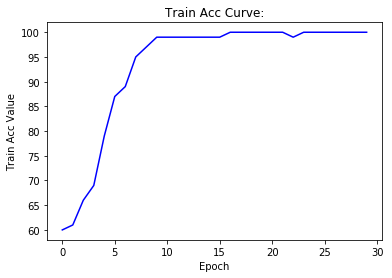

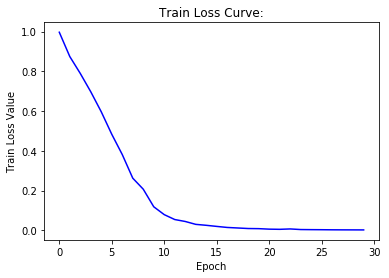

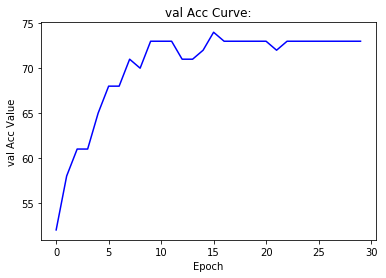

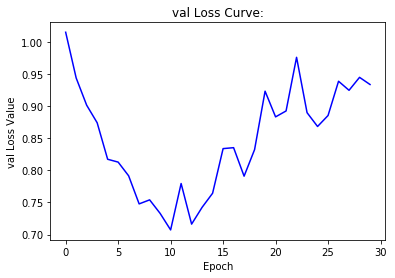

In [27]:
# ACSA Hard
show_curve(train_accs, 'Train Acc')
show_curve(train_losses, 'Train Loss')
show_curve(val_accs, 'val Acc')
show_curve(val_losses, 'val Loss')

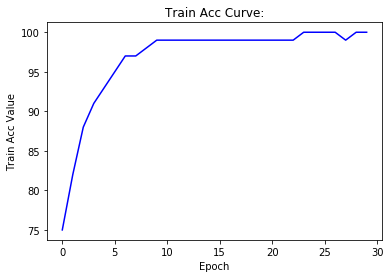

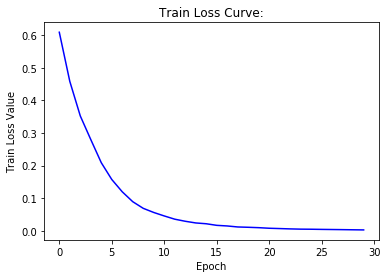

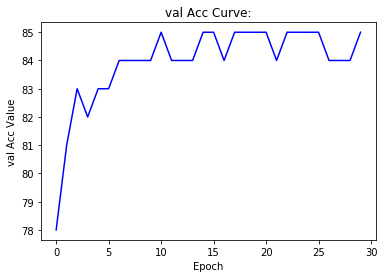

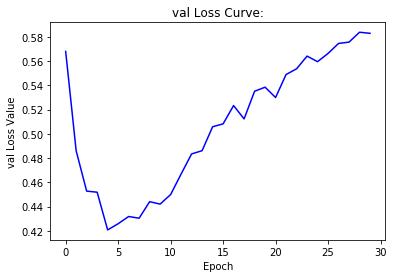

In [138]:
# ACSA 
show_curve(train_accs, 'Train Acc')
show_curve(train_losses, 'Train Loss')
show_curve(val_accs, 'val Acc')
show_curve(val_losses, 'val Loss')

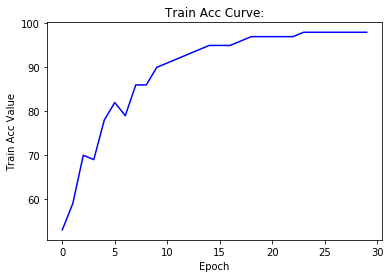

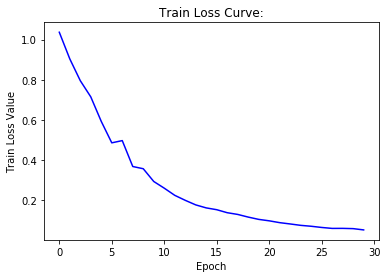

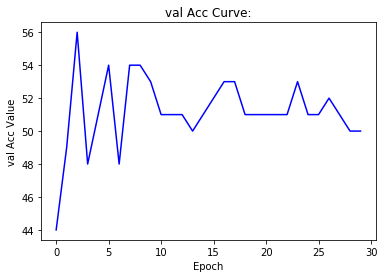

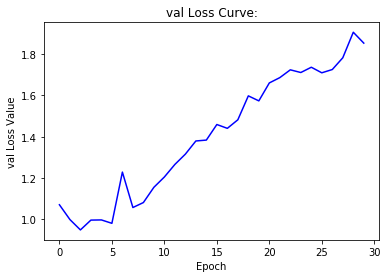

In [106]:
# ATSA HARD
show_curve(train_accs, 'Train Acc')
show_curve(train_losses, 'Train Loss')
show_curve(val_accs, 'val Acc')
show_curve(val_losses, 'val Loss')

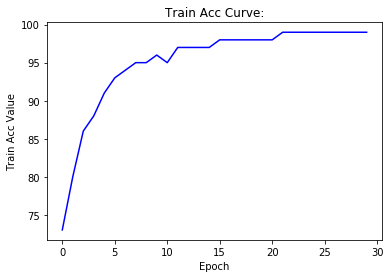

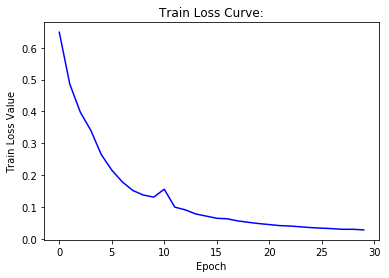

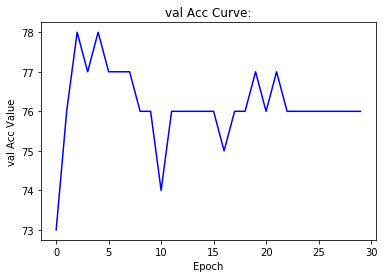

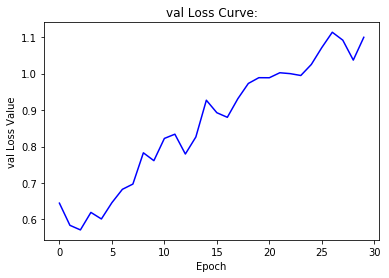

In [81]:
# ATSA
show_curve(train_accs, 'Train Acc')
show_curve(train_losses, 'Train Loss')
show_curve(val_accs, 'val Acc')
show_curve(val_losses, 'val Loss')

---

In [28]:
import re

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()

In [34]:
print(train_data[1]['sentence'])
print(clean_str(train_data[1]['sentence']))

to be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of teodora.
to be completely fair , the only redeeming factor was the food , which was above average , but could n't make up for all the other deficiencies of teodora


In [37]:
sentence_field.preprocessing = data.Pipeline(clean_str)

### Word Embedding
`w2v.py`

* Word embedding vectors are initialized with **300-dimension GloVe** vectors.
* Words **out of the vocabulary of GloVe** are randomly initialized with a **uniform distribution $U(0.25, 0.25)$**.